This methodology is thoroughly described in Douglas Hubbard's book "How to Measure Anything" . This is the best source if you want to learn more about this topic.

# Goal

The objective of this notebook is to provide a framework for calculating the value of information. To be more specific, there are many unknowns impacting a decision. This framework allows us how much value exists in reducing the uncertainty around a certain unknown.

# Expected Opportunity Loss

Many decisions are influenced by unknown events. After the event we often realise we could have made better choices. This is known as an opportunity loss: We didn't make the most of the situation because we didn't know better at the time.

Even though we cannot remove all the randomness of the world, it is possible to quantify our unknowns and understand under which scenarions we will be missing out on some profits, and when it is worth reducing the uncertainty of our predictions. In this booklet we will be using Douglas' framework of Expected Opportunity Loss.

For the given framework, I implemented the class above which requires 2 inputs only in order to be initialized:
- **Random inputs:** random number generators that model the inputs for the loss function. The random number generators that take a single integer $n$ and return $n$ observations of that input.
- **Reward Functions:** Functions that convert an observation from the random number generators into a reward amount.

The class internally applies a Monte Carlo Simulation to model the Expected Opportunity Loss using this general framework

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('precision', 2)
tqdm.pandas()

class ExpectedOpportunityLoss:
    """
    Monte Carlo Simulation Class that models expected loss using a list of random value generators and reward functions.
    """

    def __init__(self, reward_functions, random_inputs, run_default_script=False):
        """
        :param reward_functions: {str: function}
            Deterministic reward function that takes a single dictionary as input, whose keys are a subset of the keys in the random_inputs passed.
        :param random_inputs: {str: random_generator}
            dictionary of random number generators. These are functions that take a single integer input n and return an array of n randomly
        """

        assert isinstance(reward_functions, dict), "reward_functions must be a dictionary"
        assert isinstance(random_inputs, dict), "random_value_generators must be a dictionary"
        self.reward_functions = reward_functions
        self.random_inputs = random_inputs  # TODO: Allow for dependence of variables in the ramdom inputs.
        self.options = reward_functions.keys()
        self.data = pd.DataFrame(
            columns=list(self.random_inputs.keys()) + list(self.options) +
            [option + " opportunity loss" for option in self.options] + ["Optimal Decision"])
        self.colour_map = sns.color_palette("RdBu_r", 7)
        if run_default_script:
            self.main_script()

    def main_script(self):
        
        from IPython.core.display import display, HTML
        self.add_data_points(n=10000)

        display(HTML("<h1>Expected Loss and Standard Deviation for each option available</h1>"))
        display(HTML(self.generate_metrics().render()))

        display(HTML("<h1>Expected savings by knowing the inputs quantiles. The input with higher savings is more promising for making a better decision</h1>"))
        display(HTML(self.evaluate_value_of_uncertainty_reduction(bins=4).render()))
        
        display(HTML("<h1>Optimal Choices for each quantile / option</h1>"))
        for random_input in tqdm(self.random_inputs):
            display(HTML(self.get_optimal_choice_per_group(random_input, bins=4).to_html()))
        
        
    def add_data_points(self, n):
        new_data = pd.DataFrame({key: random_input(n) for key, random_input in self.random_inputs.items()})
        for key, reward_function in tqdm(self.reward_functions.items()):
            new_data[key] = new_data.apply(reward_function, axis=1)
        new_data["Optimal Decision"] = new_data[self.options].apply(max, axis=1)
        for key in self.options:
            new_data[key + " opportunity loss"] = new_data["Optimal Decision"] - new_data[key]
        self.data = pd.concat([self.data, new_data], ignore_index=True).astype(float)

    def _generate_single_metric(self, option):
        """
        Generates the expected_loss and std_deviation for a single option
        """

        return {"Expected Loss": np.mean(self.data[option + " opportunity loss"]),
                "Standard Deviation": np.std(self.data[option + " opportunity loss"])}

    def generate_metrics(self):
        """
        Generates the metrics table.
        """
        self.metrics = pd.DataFrame({
            option: self._generate_single_metric(option) for option in self.options})
        return self.metrics.sort_values("Expected Loss", ascending=True, axis=1).round(3).T.style.bar(subset=["Expected Loss"], color='#d65f5f', vmin=0)
    
    def evaluate_value_of_uncertainty_reduction(self, bins=5):
        """
        Metrics for the evaluation of which random inputs are worth decreasing the uncertainty of
        
        :param bins: integer
        Number of bins to divide the inputs in. Too small a value might cause you to miss certain relations. Too small a value might cause you to overfit to the data.
        """
  
        savings = {random_input: self.metrics.T["Expected Loss"].min() - self._expected_loss_given_group(pd.qcut(self.data[random_input],q=bins, duplicates="drop")) for random_input in self.random_inputs.keys()}
        savings_df = pd.DataFrame({"Savings" : savings})
        return savings_df.sort_values(["Savings"], ascending=False).style.bar(color = '#5fba7d',
                                                                             vmin = 0,
                                                                             vmax = self.metrics.T["Expected Loss"].min())        

        
    def _get_optimal_choices_per_group(self, groups):
        """
        Returns a Dictionary of Optimal Choices per Group
        """
        return self.data[[option + " opportunity loss" for option in self.options]].groupby(groups).progress_apply(np.mean).idxmin(axis=1).to_dict()
    
    def _expected_loss_given_group(self,groups):
        """
        Returns the expected loss assuming we know exactly in which group we are from the passed Series.
        The series must map the indices in cls.data to the categorical groups
        """
        optimal_choices_per_group = self._get_optimal_choices_per_group(groups)
        return self.data.apply(lambda row: row[optimal_choices_per_group[groups[row.name]]], axis=1).mean()
      
    def get_optimal_choice_per_group(self, random_input, bins):
        assert random_input in self.random_inputs, "The selected input is invalid. Make sure you typed it correctly, or check in the randow_inputs attribute which ones are available"
        optimal_choices = self._get_optimal_choices_per_group(groups = pd.qcut(self.data[random_input],q=bins, duplicates="drop"))
        optimal_choices = {key: value[:-17] for key,value in optimal_choices.items()} # Removes the opportunity loss part of the string
        return pd.DataFrame({"Optimal Choice for " + random_input: optimal_choices})
    
    def plot_loss_distribution(self, options=None):
        """
        Plots the loss function to 
        """
        if options is None:
            options = self.options
        assert set(options) <= set(
            self.options), "You passed choices that were not part of this object's initialization"
        loss_columns = [option + " opportunity loss" for option in options]
        bins = np.linspace(self.data[loss_columns].min().min(),
                           self.data[loss_columns].max().max(),
                           200)
        self.data.hist(column=loss_columns,
                       figsize=(30, 2 * len(options)),
                       density=True,
                       layout=(len(options), 1),
                       sharex=True,
                       bins=bins)

/home/migueltorrescosta/.local/lib/python3.8/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Study Case 1: Endorsements

Nothing better than an example to understand the concepts above. Suppose I believe that, next year, Candidate X will get elected with probability 80%. I can endorse her campaign for 2 million dollars. If I don't endorse her campaign, I get nothing. If I endorse her and she loses, I lose the 2 million dollars invested, whereas if I endorse her and she wins, I get 3 million back for an overal profit of 1 million.

As such my best move is to endorse her if she wins, and not if she doesn't. Since I don't know whether she will win or not, I have to make this choice based on probabilities. Using the class above, the first thing I need is to define the loss functions

In [2]:
def reward_if_endorse(obs):
    if obs["Elected"]==1:
        return 1 # Get 1 million overall if elected
    else:
        return -2 # Lose 2 million if not elected

In [3]:
endorsement_analysis = ExpectedOpportunityLoss(
    reward_functions = {
        "Endorse": reward_if_endorse,
        "Don't Endorse": lambda obs: 0 # Known profit of 0 if no endorsment happens
    },
    random_inputs = {
        "Elected": lambda n: np.random.binomial(size=n, n=1, p= 0.7)
    }
)

In [4]:
endorsement_analysis.add_data_points(1000)
endorsement_analysis.generate_metrics()

100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


,Expected Loss,Standard Deviation
Endorse,0.61,0.92
Don't Endorse,0.70,0.46


We see that the the lowest expected loss is attainned if we endorse the candidate, for an expected opportunity loss of around 0.6 million if we endorse her versus an expected opportunity loss of 0.7 if we don't endorse.

Note that we also have the standard deviation of our losses, since the expected loss only gives us an average value, but we can have two very different distributions for the opportunity loss. This Opportunity Loss can be thought of as a random variable as well, being a function of other random variables. We can see the distribution below

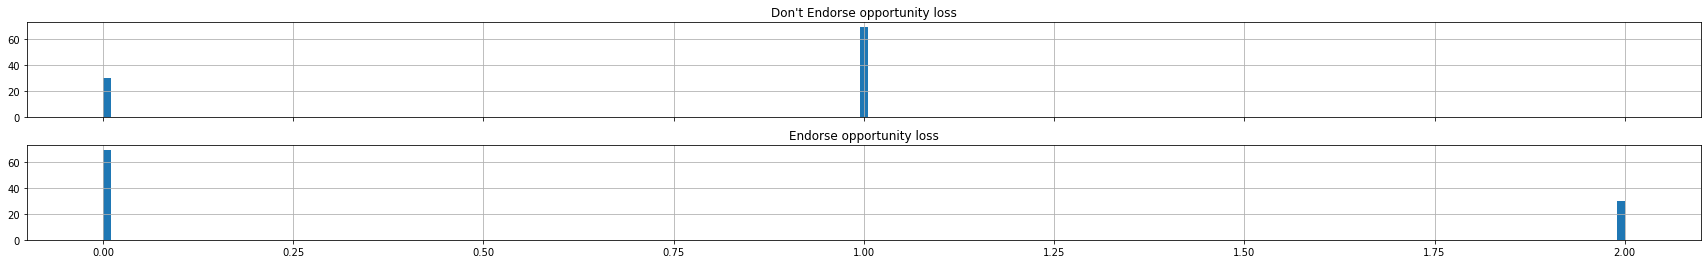

In [5]:
endorsement_analysis.plot_loss_distribution() # Need to add labels and overlap the barchart1

# Study Case 2: Distribution Centers
Now let us try a much harder example. Say we manage a distribution center and on any given day we distribute packages. The costs associated are described by $N_{Trucks} * M $ (the number of trucks multiplied by the average maintenance costs per truck), and the profit is $\min( N_{packages}, N_{Trucks} * C ) * P$, where the first term represents the number of packages that can be handled for a given day (the minimum between the number of requests made and the capacity that the company has), and the second term represents the average profit per package. As such the overal reward function is given by:

$$ \min( N_{packages}, N_{Trucks} * C ) P - M N_{Trucks}$$

In this equation:

- $N_{packages}$ is the number of packages sent by clients. Assuming 10 million Portuguese possible clients, each with a probibility of 0.1% of sending a package on a given day, and independent of each other, we get that this is a random variable with a binomial distribution with parameters $n=10^7$ and $p=10^{-3}$.
- $N_{trucks}$ Is the only variable we control. Let's assume we currently have 8 trucks, and can get a total of up to 12 trucks.
- $C$ represents the truck capacity. This is currently given as $10^3$, for each truck.
- $M$ is the costs per truck. Each truck costs us a fixed amount of $50€$ per day, but we could potentially pay up to $500€$ for repairs. As such this is uniform on the interval $(50,500)$.

As such our reward functions are given by the distinct choices we can make regarding the number of trucks, and the other variable represent random inputs. The code below represents this

In [6]:
options_list = [x for x in range(13) if x>=8] # We already have 8 trucks, and we can buy up to 12

In [7]:
def reward_function(obs,number_of_trucks):
    truck_capacity = 1000 # A truck can carry 1000 packages a day
    return (min([obs["Number of Packages"],number_of_trucks*truck_capacity]) * obs["Profit per Package"]) - (number_of_trucks * obs["Maintenance cost per Truck"])

In [8]:
from functools import partial

distribution_center_analysis = ExpectedOpportunityLoss(
    reward_functions = {
        f"{key} trucks": partial(reward_function, number_of_trucks=key) for key in options_list
    },
    random_inputs = {
        "Number of Packages" : lambda n : np.random.binomial(size=n, n=10000000, p = 0.001), # There's 10 million people, each of which with .1 % chance of sending a package that day
        "Profit per Package" : lambda n: np.random.exponential(size=n, scale=3), # Package profits are exponentially distributed, with average 3 euros per package but a lower bound of 1.
        "Maintenance cost per Truck" : lambda n : np.random.uniform(50,500, size=n) # Maintenance of trucks has a fixed cost of 50€ per truck (man work) + extra if replacements are needed
    }
)

In [9]:
distribution_center_analysis.add_data_points(10000)
distribution_center_analysis.generate_metrics()

100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


,Expected Loss,Standard Deviation
10 trucks,86.12,233.92
11 trucks,244.14,222.44
12 trucks,519.62,318.88
9 trucks,2704.26,2966.60
8 trucks,5445.09,5974.02


We see that 10 trucks is the best choice, with an expected opportunity loss around 90. The next best choice, 11 trucks, has a much bigger loss, around 240.


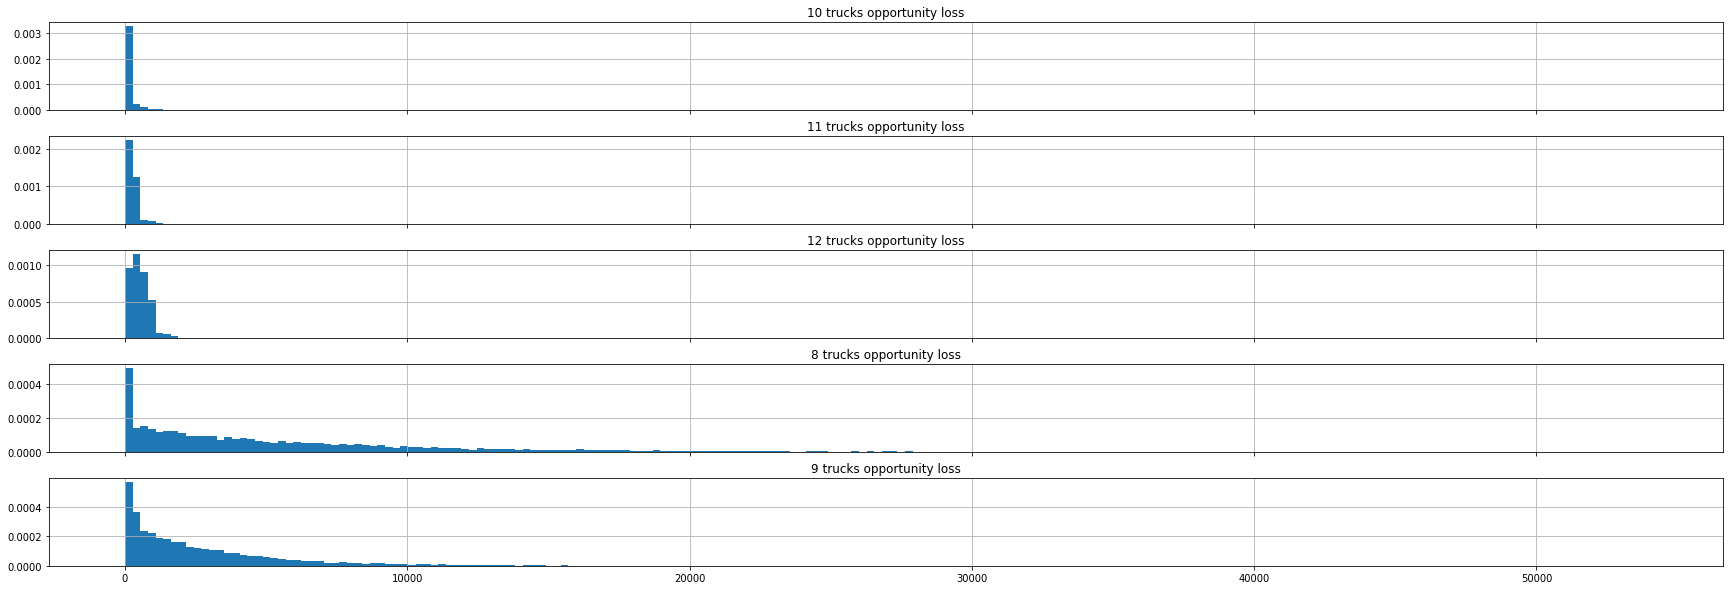

In [10]:
distribution_center_analysis.plot_loss_distribution()

In [11]:
distribution_center_analysis.evaluate_value_of_uncertainty_reduction(bins=4)

100%|██████████| 4/4 [00:00<00:00, 413.73it/s]


,Savings
Number of Packages,24.33
Maintenance cost per Truck,4.32
Profit per Package,0.04


Assuming we knew exactly which distribution quantile we were in for the input variables above, we can see exactly which one provides the biggest improvement in Expected Loss: Knowing the Number of Packages. As such reducing uncertainty around the Number of packages per day is more likely to reduce the expected loss.

In [12]:
distribution_center_analysis.get_optimal_choice_per_group(random_input="Number of Packages", bins=4)

100%|██████████| 4/4 [00:00<00:00, 317.00it/s]


,Optimal Choice for Number of Packages
"(9627.999, 9932.0]",10 trucks
"(9932.0, 10000.0]",10 trucks
"(10000.0, 10068.0]",10 trucks
"(10068.0, 10348.0]",11 trucks


Looking at the optimal choice per group, we can observe that the reduction in opportunity loss comes from knowing that in the upper quantile, above roughly 10000 packages, the best option is to get 11 trucks. This makes intuitive sense: If the expected number of packages is higher, more trucks will be needed to handle the demand.

In [13]:
distribution_center_analysis.evaluate_value_of_uncertainty_reduction(bins=10)

100%|██████████| 10/10 [00:00<00:00, 824.01it/s]


,Savings
Profit per Package,36.97
Number of Packages,27.02
Maintenance cost per Truck,5.52


If we knew deciles, however, the picture changes: Knowing the profit per package now surpasses knowing the number of packages. This can be interpreted by thinking of marginal returns: An initial reduction in knowing the expected number of packages reduces our uncertainty significantly up to a certain amount, after which we might be better off reducing uncertainty around the Profit per package.

In [14]:
distribution_center_analysis.evaluate_value_of_uncertainty_reduction(bins=100)

100%|██████████| 100/100 [00:00<00:00, 1744.12it/s]


,Savings
Profit per Package,38.24
Number of Packages,27.69
Maintenance cost per Truck,6.64


The above shows that even knowing the percentile of a given input is not enough for fully reducing Expected Loss. This reveals one of the limitations of this approach: It only shows improvements related to measuring one variable, while keeping the other ones with their original distribution. This misses interactions between measurements on different inputs.

As such we follow a greedy strategy: by the above the greatest improvement comes from measuring the Number of Packages. Afterwards we rerun this class with the new and more accurate distribution, and calculate the next cheapest measurement we can make in order to reduce uncertainty around the final decision.

# Study case 3: Boeing buybacks decision

A few years back, Boeing had a surplus of cash. As such, it had the option of buying back it's shares. With a lerger amount of shares it would own more of it's own profits, in the form of dividends. With more cash, the company is more robust to financial hits due to it's extra liquidity. The question at hand is how much of it's shares should the company buyback. The companies monetary reward is given by:

$$ (M-SC) + S(1+r)^5 - KP  $$

Where:
- $M$ is the initial amount of money
- $S$ is the amount of self owned shares / Amount of shares bought
- $r$ is the company yearly average return (geometric mean)
- $C$ is the current share price
- $K$ is the number of kilometres flown by the fleet.
- $P$ is the current cost of petrol per kilometrer flown

- The profits come from number of tickets bought times average ticket price, plus the companies self owned shares 
- Costs include flight costs, which is the gasoline cost per mile times the average number of miles flown.



As such the formula becomes

In [120]:
boeing_analysis.data.head()

,Boeing Shares Return,Kilometres flown,Petrol Cost,Loan Rate,Buy 1 shares,Buy 100 shares,Buy 10000 shares,Buy 1000000 shares,Buy 100000000 shares,Buy 10000000000 shares,Buy 1 shares opportunity loss,Buy 100 shares opportunity loss,Buy 10000 shares opportunity loss,Buy 1000000 shares opportunity loss,Buy 100000000 shares opportunity loss,Buy 10000000000 shares opportunity loss,Optimal Decision
0,3.48,10024.0,33.50,0.10,9.97e+07,9.97e+07,9.95e+07,8.58e+07,-4.31e+09,-4.47e+11,0.0,1369.42,138311.09,1.38e+07,4.41e+09,4.47e+11,9.97e+07
1,3.48,9940.0,33.55,0.29,9.97e+07,9.97e+07,9.95e+07,8.58e+07,-1.37e+10,-1.41e+12,0.0,1368.50,138218.49,1.38e+07,1.38e+10,1.41e+12,9.97e+07
2,3.48,9909.0,34.06,0.30,9.97e+07,9.97e+07,9.95e+07,8.58e+07,-1.45e+10,-1.48e+12,0.0,1371.66,138537.39,1.39e+07,1.46e+10,1.48e+12,9.97e+07
3,3.48,9831.0,39.54,0.27,9.96e+07,9.96e+07,9.95e+07,8.58e+07,-1.25e+10,-1.28e+12,0.0,1369.69,138338.80,1.38e+07,1.26e+10,1.28e+12,9.96e+07
4,3.48,9971.0,39.83,0.22,9.96e+07,9.96e+07,9.95e+07,8.57e+07,-9.59e+09,-9.86e+11,0.0,1371.54,138525.56,1.39e+07,9.69e+09,9.86e+11,9.96e+07


In [151]:
def boeing_reward_function(obs, amount_of_shares_bought):
    m = 10 # Initial amount of money: 100 million
    boeing_share_price = 500000 # Present cost of Boeing Shares    
    value_of_shares = np.divide(amount_of_shares_bought, boeing_share_price)*(1+obs["Boeing Shares Return"])**5
    flying_costs = obs["Kilometres flown"]*obs["Petrol Cost"]
    liquidity = m-(amount_of_shares_bought*boeing_share_price) - flying_costs
    if liquidity < 0:
        liquidity_value = liquidity * (1 + obs["Loan Rate"])**5
    else: 
        liquidity_value = liquidity
    return liquidity_value + value_of_shares

boeing_analysis = ExpectedOpportunityLoss(
    reward_functions = {
        f"Buy {number_of_shares} shares": partial(boeing_reward_function, amount_of_shares_bought=number_of_shares) for number_of_shares in [int(x) for x in np.geomspace(1,10**10,6)]
    },
    random_inputs = {
        "Boeing Shares Return" : lambda n: [np.exp(x)-1 for x in np.random.normal(size=n, loc=3, scale=.0001)], # log normally distributed returns, with average 0 and std_dev 1
        "Kilometres flown" : lambda n: np.random.binomial(size=n, n=100000000, p=0.0001), # The kilometres flown is binomial since it is roughly proportional to the number of kilomtres people fly in total
        "Petrol Cost" : lambda n : np.random.uniform(size=n,low=30,high=40), # The petrol cost is around 30 to 40 a barrel
        "Loan Rate" : lambda n : np.random.uniform(size=n,low=.1,high=.3) # Emergency Loan Rate if the liquidity goes below zero
    },
)

In [152]:
boeing_analysis.add_data_points(10000)
boeing_analysis.generate_metrics()

100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


,Expected Loss,Standard Deviation
Buy 1 shares,0.00,0.00
Buy 100 shares,125986628.48,30194126.22
Buy 10000 shares,12724649476.82,3049606748.44
Buy 1000000 shares,1272590934310.30,304990868970.44
Buy 100000000 shares,127259219417658.98,30499117091169.92
Buy 10000000000 shares,12725922067752528.00,3049911739311118.50


In [134]:
boeing_analysis.evaluate_value_of_uncertainty_reduction(bins=100)

100%|██████████| 100/100 [00:00<00:00, 1649.40it/s]


,Savings
Boeing Shares Return,0.00
Kilometres flown,0.00
Loan Rate,0.00
Petrol Cost,0.00


# Do you have another study case? Reach out for us to discuss it